In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install segmentation_models_pytorch

In [4]:
# ============================================================
# 0) SETUP & IMPORTS
# ============================================================
import os
import random
import zipfile
from pathlib import Path

import numpy as np
import cv2
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

import albumentations as A
from albumentations.pytorch import ToTensorV2

from pycocotools.coco import COCO
import segmentation_models_pytorch as smp

# ---------------------------
# Reproducibility
# ---------------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

In [5]:

# Define paths to your data folders
TRAIN_IMG_DIR = "/content/drive/MyDrive/advancemethods/RM_Segmentation_Assignment_dataset/train-300/data"
VAL_IMG_DIR = "/content/drive/MyDrive/advancemethods/RM_Segmentation_Assignment_dataset/validation-300/data"
TEST_IMG_DIR = "/content/drive/MyDrive/advancemethods/RM_Segmentation_Assignment_dataset/test-30"
TRAIN_ANN  = "/content/drive/MyDrive/advancemethods/RM_Segmentation_Assignment_dataset/train-300/labels.json"
VAL_ANN    = "/content/drive/MyDrive/advancemethods/RM_Segmentation_Assignment_dataset/validation-300/labels.json"


# If your dataset categories differ, change here:
TARGET_CLASSES = ['cake', 'car', 'dog', 'person']  # <- adjust to ['cake','cat','dog','person'] if needed

In [6]:


# ============================================================
# 2) DATASET
# ============================================================
class COCOSegmentationDataset(Dataset):
    """
    Produces (image_tensor, mask_tensor) where:
      - image: FloatTensor [3,H,W], normalized
      - mask:  FloatTensor [1,H,W], binary (target classes merged)
    """
    def __init__(self, img_dir, ann_file, transforms=None, target_classes=TARGET_CLASSES):
        super().__init__()
        self.coco = COCO(ann_file)
        self.img_dir = img_dir
        self.img_ids = self.coco.getImgIds()
        self.transforms = transforms

        # Build mapping and filter target classes present in the dataset
        cats = self.coco.loadCats(self.coco.getCatIds())
        self.class_name_to_id = {c['name']: c['id'] for c in cats}
        self.target_class_ids = [self.class_name_to_id[n] for n in target_classes if n in self.class_name_to_id]

        if len(self.target_class_ids) == 0:
            print(f"[WARN] None of {target_classes} found in annotation categories. "
                  f"Available: {list(self.class_name_to_id.keys())}")

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        img_info = self.coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.img_dir, img_info['file_name'])

        image = cv2.imread(img_path)
        if image is None:
            raise FileNotFoundError(f"Image not found at: {img_path}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)

        # Binary mask for union of target classes
        mask = np.zeros((img_info['height'], img_info['width']), dtype=np.uint8)
        for ann in anns:
            if ann.get('category_id') in self.target_class_ids and ann.get('segmentation'):
                try:
                    m = self.coco.annToMask(ann)
                    mask = np.maximum(mask, m)
                except Exception as e:
                    # Skip problematic polygons/RLEs without breaking the dataloader
                    print(f"Skipping annotation {ann.get('id')} error: {e}")
                    continue

        if self.transforms:
            augmented = self.transforms(image=image, mask=mask)
            image = augmented['image']
            # ToTensorV2 -> mask becomes torch.Tensor [H,W]; we need shape [1,H,W]
            mask = augmented['mask'].unsqueeze(0).float()
        else:
            # Fallback: convert to tensor manually (shouldn't happen here)
            image = torch.from_numpy(image.transpose(2, 0, 1)).float() / 255.0
            mask = torch.from_numpy(mask).unsqueeze(0).float()

        return image, mask

In [7]:
# ============================================================
# 3) TRANSFORMS & DATALOADERS
#    (ImageNet normalization aligns with the pretrained encoder)
# ============================================================
train_transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    # Optional stronger augmentations (uncomment to try):
    # A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=10, p=0.5),
    # A.RandomResizedCrop(256, 256, scale=(0.7, 1.0), p=0.5),
    # A.GaussNoise(p=0.1),
    # A.Blur(p=0.1),

    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

val_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

train_ds = COCOSegmentationDataset(TRAIN_IMG_DIR, TRAIN_ANN, transforms=train_transform, target_classes=TARGET_CLASSES)
val_ds   = COCOSegmentationDataset(VAL_IMG_DIR,   VAL_ANN,   transforms=val_transform,   target_classes=TARGET_CLASSES)

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=8, shuffle=False, num_workers=2, pin_memory=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

loading annotations into memory...
Done (t=0.74s)
creating index...
index created!
loading annotations into memory...
Done (t=0.43s)
creating index...
index created!
Device: cuda



[EDA] Random train samples (image + multi-class mask)


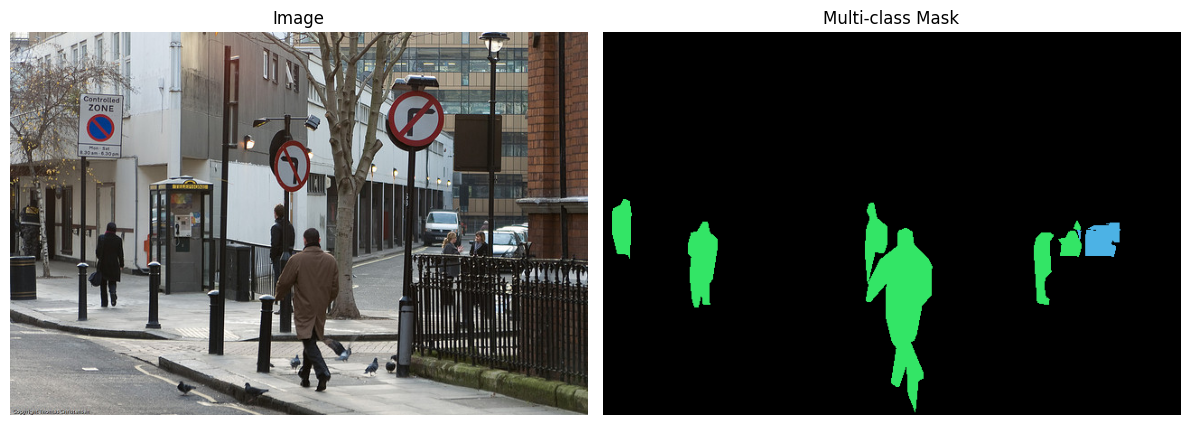

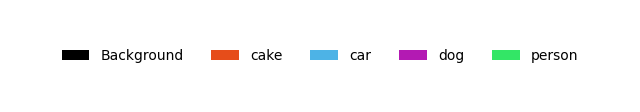

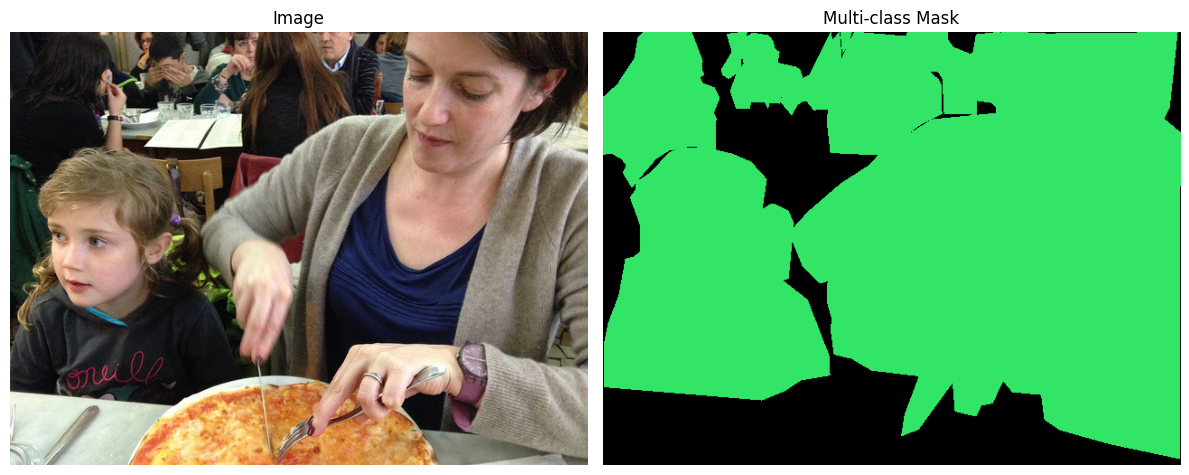

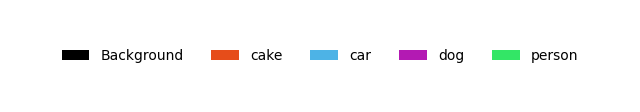

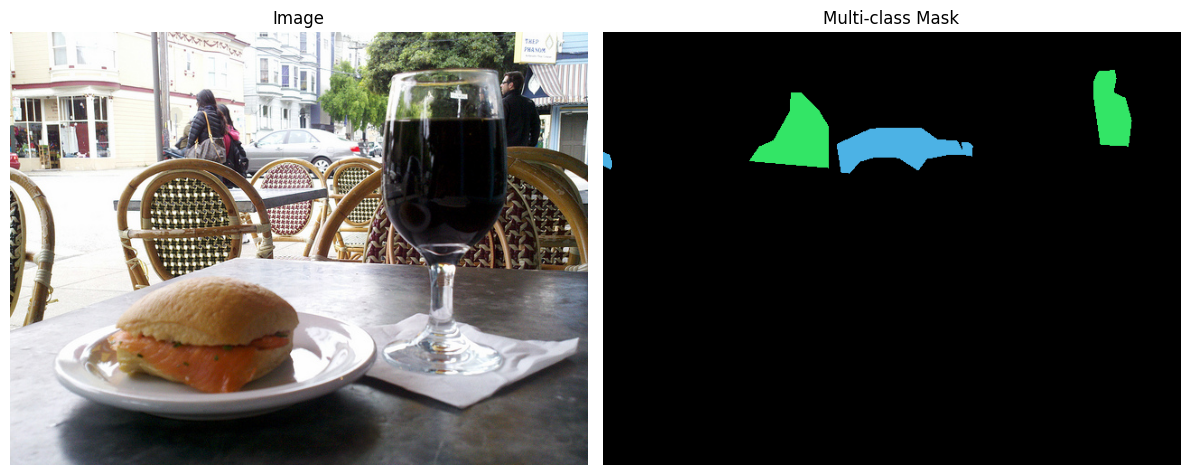

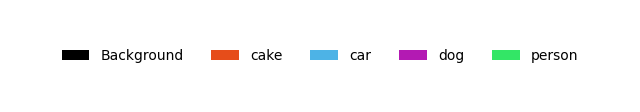


[EDA] Random val samples (image + multi-class mask)


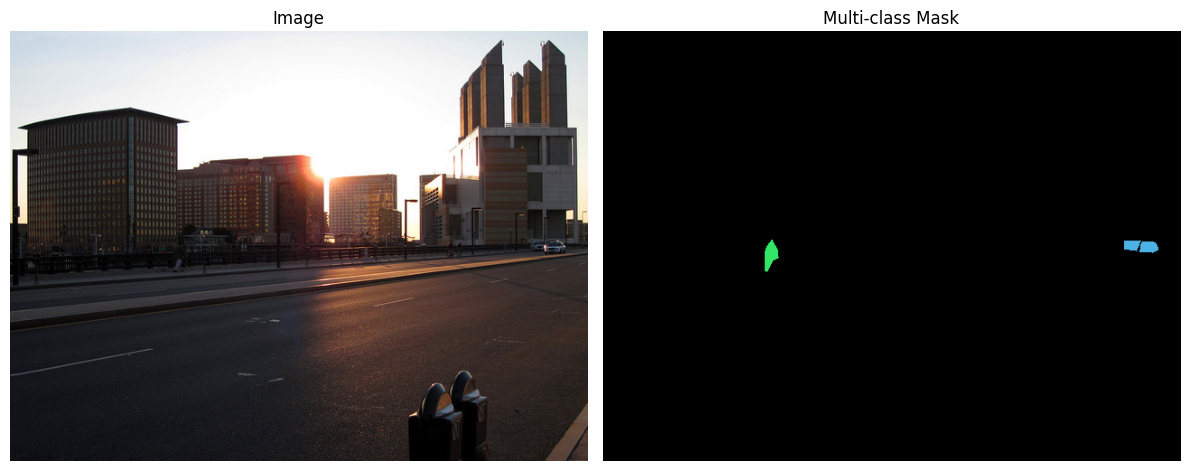

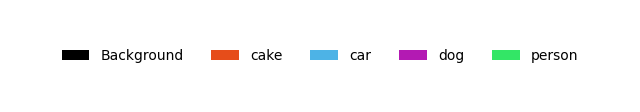

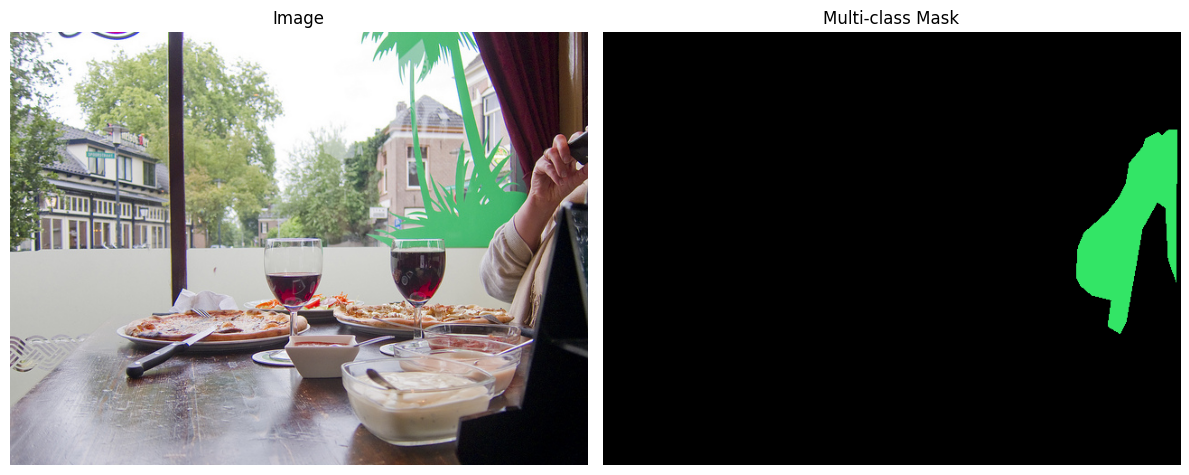

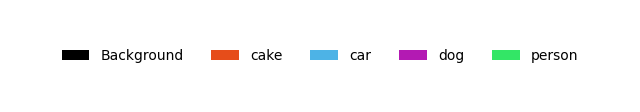

In [21]:
# ============================================================
# EDA: Visualize multi-class masks on a few samples (TRAIN)
# ============================================================
from matplotlib.patches import Patch

# Palette values are floats in [0,1]; first row is a placeholder (background added separately)
SEG_MASK_PALETTE = np.array([
    [0.0, 0.0, 0.0],      # (placeholder; background is added explicitly below)
    [0.9, 0.3, 0.1],      # Cake: Orange
    [0.3, 0.7, 0.9],      # Car:   Cyan
    [0.7, 0.1, 0.7],      # Dog:   Purple
    [0.2, 0.9, 0.4],      # Person: Light green
], dtype=float)

def visualize_segmentation_mask(coco, img_id, img_dir, palette, class_names):
    """
    Shows (Image, Multi-class Mask) for a COCO img_id.
    Class indices: 0 = background, 1..K = classes in class_names order.
    """
    # --- Load image
    info = coco.loadImgs([img_id])[0]
    img_path = os.path.join(img_dir, info["file_name"])
    img = cv2.imread(img_path)
    if img is None:
        raise FileNotFoundError(f"Image not found: {img_path}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # --- Build mapping (COCO category_id -> compact label) following class_names order
    target_category_ids = coco.getCatIds(catNms=class_names)
    cats = coco.loadCats(target_category_ids)
    name_to_compact = {n: i+1 for i, n in enumerate(class_names)}  # 1..K
    category_id_to_label = {}
    for c in cats:
        if c['name'] in name_to_compact:
            category_id_to_label[c['id']] = name_to_compact[c['name']]

    # --- Multi-class mask
    mask = np.zeros((info['height'], info['width']), dtype=np.uint8)
    ann_ids = coco.getAnnIds(imgIds=img_id, catIds=target_category_ids, iscrowd=None)
    for ann in coco.loadAnns(ann_ids):
        if ann.get('segmentation') and ann['category_id'] in category_id_to_label:
            try:
                m = coco.annToMask(ann).astype(np.uint8)
                mask = np.maximum(mask, m * category_id_to_label[ann['category_id']])
            except Exception as e:
                print(f"Skip ann {ann.get('id')} err: {e}")

    # --- Extended palette: 0=background + colors for classes
    num_classes = len(class_names) + 1
    extended_palette = np.vstack([np.array([[0.0, 0.0, 0.0]]), palette[1:1+len(class_names)]])
    mask_rgb = (extended_palette[mask] * 255).astype(np.uint8)

    # --- Plot image & mask
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1); plt.imshow(img);      plt.title("Image");          plt.axis('off')
    plt.subplot(1, 2, 2); plt.imshow(mask_rgb); plt.title("Multi-class Mask"); plt.axis('off')
    plt.tight_layout(); plt.show()

    # --- Legend
    handles = [Patch(facecolor=extended_palette[i], edgecolor='none') for i in range(num_classes)]
    labels  = ['Background'] + class_names
    plt.figure(figsize=(8, 1.2))
    plt.legend(handles, labels, loc='center', ncol=num_classes, frameon=False)
    plt.axis('off')
    plt.show()

# Show a few random train samples
print("\n[EDA] Random train samples (image + multi-class mask)")
for imgid in random.sample(train_ds.img_ids, k=min(3, len(train_ds.img_ids))):
    visualize_segmentation_mask(train_ds.coco, imgid, TRAIN_IMG_DIR, SEG_MASK_PALETTE, TARGET_CLASSES)

# (Optional) A couple from the validation split too
print("\n[EDA] Random val samples (image + multi-class mask)")
for imgid in random.sample(val_ds.img_ids, k=min(2, len(val_ds.img_ids))):
    visualize_segmentation_mask(val_ds.coco, imgid, VAL_IMG_DIR, SEG_MASK_PALETTE, TARGET_CLASSES)


In [ ]:
# ============================================================
# 4) MODEL
# ============================================================
model = smp.FPN(
    encoder_name='resnet34',
    encoder_weights='imagenet',
    in_channels=3,
    classes=1,         # binary (union of target classes)
    activation=None    # we'll use logits + sigmoid later
).to(device)

In [9]:
# ============================================================
# 5) LOSSES (BCE + Dice) & METRICS
# ============================================================
bce = torch.nn.BCEWithLogitsLoss()

def dice_loss_from_logits(logits, targets, eps=1e-7):
    prob = torch.sigmoid(logits)
    targets = targets.float()
    inter = torch.sum(prob * targets, dim=(2, 3))
    union = torch.sum(prob, dim=(2, 3)) + torch.sum(targets, dim=(2, 3))
    dice = (2 * inter + eps) / (union + eps)
    return 1 - dice.mean()

def bce_dice_loss(logits, targets, alpha=0.5):
    """ alpha balances BCE vs Dice. alpha=0.5 means equal weight. """
    return alpha * bce(logits, targets) + (1 - alpha) * dice_loss_from_logits(logits, targets)

@torch.no_grad()
def batch_metrics_from_logits(logits, targets, thr=0.5, eps=1e-7):
    probs = torch.sigmoid(logits)
    preds = (probs > thr).float()
    targets = targets.float()

    inter = (preds * targets).sum(dim=(2,3))
    union = (preds + targets - preds*targets).sum(dim=(2,3))

    iou = (inter + eps) / (union + eps)
    dice = (2*inter + eps) / ((preds.sum(dim=(2,3)) + targets.sum(dim=(2,3))) + eps)
    return iou.mean().item(), dice.mean().item()

In [ ]:
# ============================================================
# 6) OPTIMIZER, SCHEDULER, AMP, EARLY STOPPING
# ============================================================
optimizer = torch.optim.Adam(model.parameters(), lr=8e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
scaler = torch.cuda.amp.GradScaler(enabled=(device.type == 'cuda'))

PATIENCE = 6
CKPT_PATH = '/content/best_fpn_resnet34.pt'
best_val_dice = -1.0
epochs_no_improve = 0

In [12]:
# ============================================================
# 7) TRAIN/VAL LOOPS
# ============================================================
def run_epoch(loader, is_train=True):
    model.train(mode=is_train)
    total_loss, total_iou, total_dice, n_batches = 0.0, 0.0, 0.0, 0

    for images, masks in loader:
        images = images.to(device, non_blocking=True)
        masks  = masks.to(device, non_blocking=True)

        if is_train:
            optimizer.zero_grad(set_to_none=True)

        with torch.cuda.amp.autocast(enabled=(device.type=='cuda')):
            logits = model(images)
            loss = bce_dice_loss(logits, masks, alpha=0.5)

        if is_train:
            scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()

        # Metrics
        iou, dice = batch_metrics_from_logits(logits, masks, thr=0.5)
        total_loss += loss.item()
        total_iou  += iou
        total_dice += dice
        n_batches  += 1

    return (total_loss / n_batches), (total_iou / n_batches), (total_dice / n_batches)

EPOCHS = 20
history = {
    'train_loss': [], 'val_loss': [],
    'train_iou': [],  'val_iou': [],
    'train_dice':[],  'val_dice':[]
}

print(f"{'Epoch':>5} | {'TrainLoss':>9} {'ValLoss':>9} | {'TrainIoU':>8} {'ValIoU':>8} | {'TrainDice':>9} {'ValDice':>8}")
print("-"*70)

for epoch in range(1, EPOCHS+1):
    train_loss, train_iou, train_dice = run_epoch(train_loader, is_train=True)
    val_loss,   val_iou,   val_dice   = run_epoch(val_loader,   is_train=False)

    history['train_loss'].append(train_loss); history['val_loss'].append(val_loss)
    history['train_iou'].append(train_iou);   history['val_iou'].append(val_iou)
    history['train_dice'].append(train_dice); history['val_dice'].append(val_dice)

    scheduler.step(val_loss)

    print(f"{epoch:5d} | {train_loss:9.4f} {val_loss:9.4f} | {train_iou:8.4f} {val_iou:8.4f} | {train_dice:9.4f} {val_dice:8.4f}")

    # Early stopping on val Dice + checkpoint
    if val_dice > best_val_dice:
        best_val_dice = val_dice
        torch.save({
            'model': model.state_dict(),
            'epoch': epoch,
            'best_val_dice': best_val_dice
        }, CKPT_PATH)
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= PATIENCE:
            print(f"Early stopping at epoch {epoch}. Best Val Dice: {best_val_dice:.4f}")
            break

# Load best checkpoint
ckpt = torch.load(CKPT_PATH, map_location=device)
model.load_state_dict(ckpt['model'])
print(f"Loaded best model from epoch {ckpt['epoch']} with Val Dice={ckpt['best_val_dice']:.4f}")

Epoch | TrainLoss   ValLoss | TrainIoU   ValIoU | TrainDice  ValDice
----------------------------------------------------------------------


/tmp/ipython-input-2369117991.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=='cuda')):


    1 |    0.6752    0.5275 |   0.1753   0.2515 |    0.2546   0.3573
    2 |    0.4543    0.6380 |   0.3023   0.2855 |    0.4171   0.3991
    3 |    0.3902    0.6130 |   0.3858   0.2702 |    0.5137   0.3714
    4 |    0.3823    0.5776 |   0.3995   0.3121 |    0.5241   0.4225
    5 |    0.3491    0.5136 |   0.4358   0.3032 |    0.5609   0.4134
    6 |    0.3248    0.5397 |   0.4648   0.2550 |    0.5958   0.3538
    7 |    0.3103    0.4721 |   0.4792   0.3331 |    0.6082   0.4421
    8 |    0.2716    0.4753 |   0.5249   0.3401 |    0.6552   0.4508
    9 |    0.2708    0.5606 |   0.5297   0.3021 |    0.6566   0.4043
   10 |    0.2547    0.5545 |   0.5492   0.3238 |    0.6784   0.4348
   11 |    0.2539    0.5513 |   0.5613   0.3064 |    0.6860   0.4093
   12 |    0.2162    0.4803 |   0.5962   0.3663 |    0.7155   0.4822
   13 |    0.1968    0.5023 |   0.6247   0.3597 |    0.7404   0.4727
   14 |    0.1795    0.5055 |   0.6529   0.3679 |    0.7675   0.4748
   15 |    0.1800    0.5170 |   0.

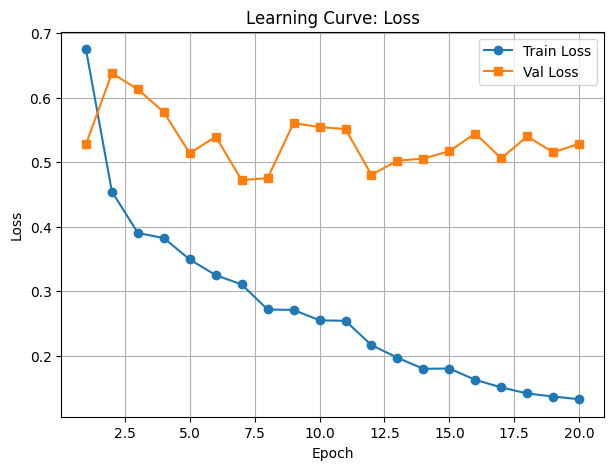

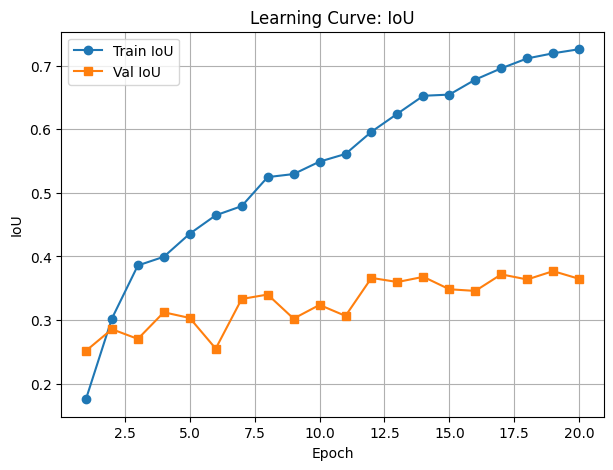

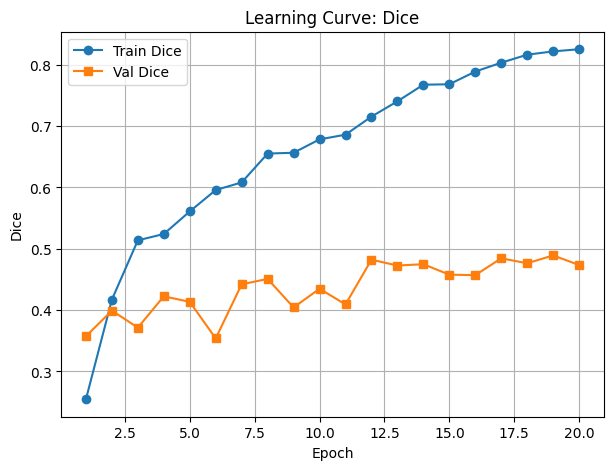

In [13]:
# ============================================================
# 8) LEARNING CURVES (Loss, IoU, Dice)
# ============================================================
epochs_ran = range(1, len(history['train_loss'])+1)

plt.figure(figsize=(7,5))
plt.plot(epochs_ran, history['train_loss'], marker='o', label='Train Loss')
plt.plot(epochs_ran, history['val_loss'],   marker='s', label='Val Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Learning Curve: Loss'); plt.grid(True); plt.legend(); plt.show()

plt.figure(figsize=(7,5))
plt.plot(epochs_ran, history['train_iou'],  marker='o', label='Train IoU')
plt.plot(epochs_ran, history['val_iou'],    marker='s', label='Val IoU')
plt.xlabel('Epoch'); plt.ylabel('IoU'); plt.title('Learning Curve: IoU'); plt.grid(True); plt.legend(); plt.show()

plt.figure(figsize=(7,5))
plt.plot(epochs_ran, history['train_dice'], marker='o', label='Train Dice')
plt.plot(epochs_ran, history['val_dice'],   marker='s', label='Val Dice')
plt.xlabel('Epoch'); plt.ylabel('Dice'); plt.title('Learning Curve: Dice'); plt.grid(True); plt.legend(); plt.show()

/tmp/ipython-input-489586191.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=(device.type=='cuda')):


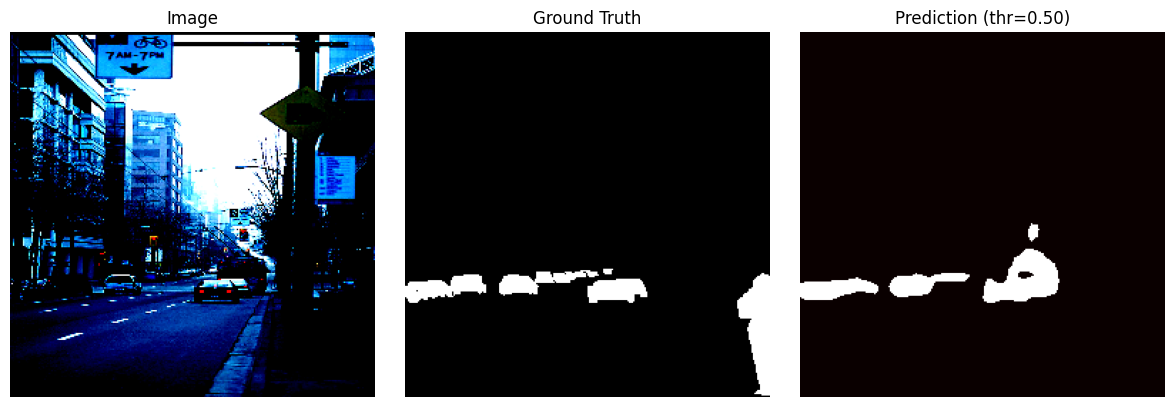

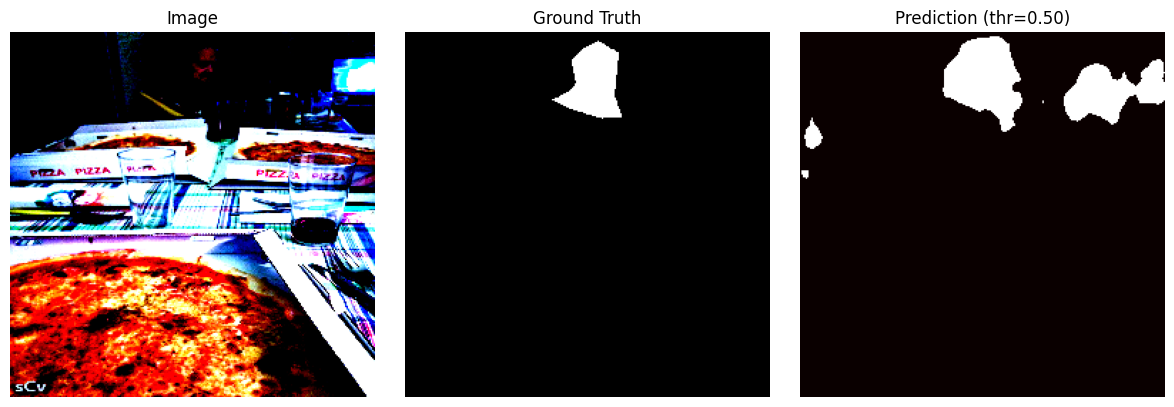

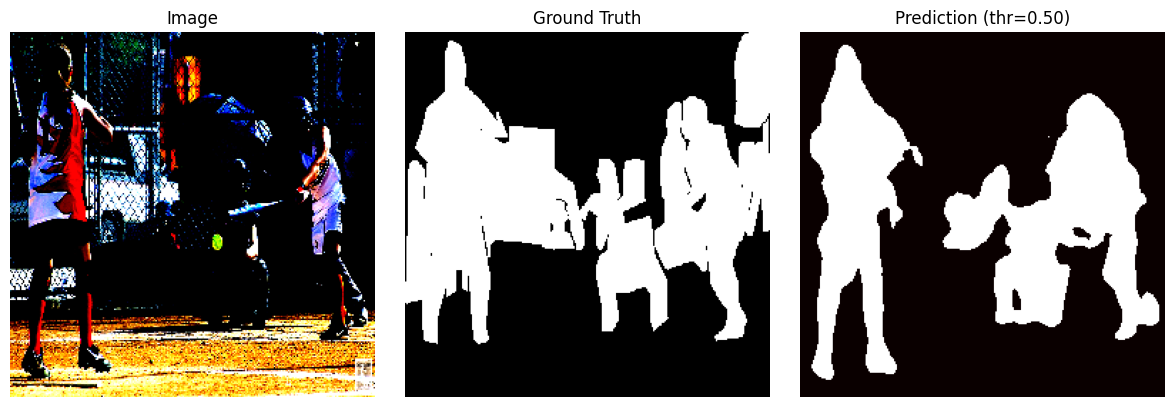

In [14]:
# ============================================================
# 9) QUALITATIVE PREDICTIONS
# ============================================================
def show_predictions(model, dataset, num=3, thr=0.5):
    model.eval()
    import random
    indices = random.sample(range(len(dataset)), k=min(num, len(dataset)))
    for idx in indices:
        img, gt_mask = dataset[idx]
        with torch.no_grad(), torch.cuda.amp.autocast(enabled=(device.type=='cuda')):
            logits = model(img.unsqueeze(0).to(device))
            prob = torch.sigmoid(logits)[0, 0].cpu().numpy()
        pred_bin = (prob > thr).astype(np.uint8)

        fig, axs = plt.subplots(1, 3, figsize=(12, 4))
        axs[0].imshow(np.transpose(img.numpy(), (1, 2, 0)))
        axs[0].set_title("Image"); axs[0].axis('off')
        axs[1].imshow(gt_mask[0].numpy(), cmap='gray')
        axs[1].set_title("Ground Truth"); axs[1].axis('off')
        axs[2].imshow(pred_bin, cmap='hot')
        axs[2].set_title(f"Prediction (thr={thr:.2f})"); axs[2].axis('off')
        plt.tight_layout(); plt.show()

show_predictions(model, val_ds, num=3, thr=0.5)

/tmp/ipython-input-966421568.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=='cuda')):
/tmp/ipython-input-489586191.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=(device.type=='cuda')):



Threshold sweep (thr, mean IoU, mean Dice):
0.20  IoU=0.3851  Dice=0.5013
0.25  IoU=0.3846  Dice=0.5000
0.30  IoU=0.3836  Dice=0.4982
0.35  IoU=0.3825  Dice=0.4964
0.40  IoU=0.3810  Dice=0.4944
0.45  IoU=0.3790  Dice=0.4918
0.50  IoU=0.3769  Dice=0.4892
0.55  IoU=0.3747  Dice=0.4866
0.60  IoU=0.3722  Dice=0.4838
0.65  IoU=0.3690  Dice=0.4802
0.70  IoU=0.3650  Dice=0.4758
0.75  IoU=0.3598  Dice=0.4701
0.80  IoU=0.3529  Dice=0.4627

Best threshold by Dice: 0.20 (Dice=0.5013, IoU=0.3851)
Best threshold by IoU : 0.20 (IoU=0.3851, Dice=0.5013)


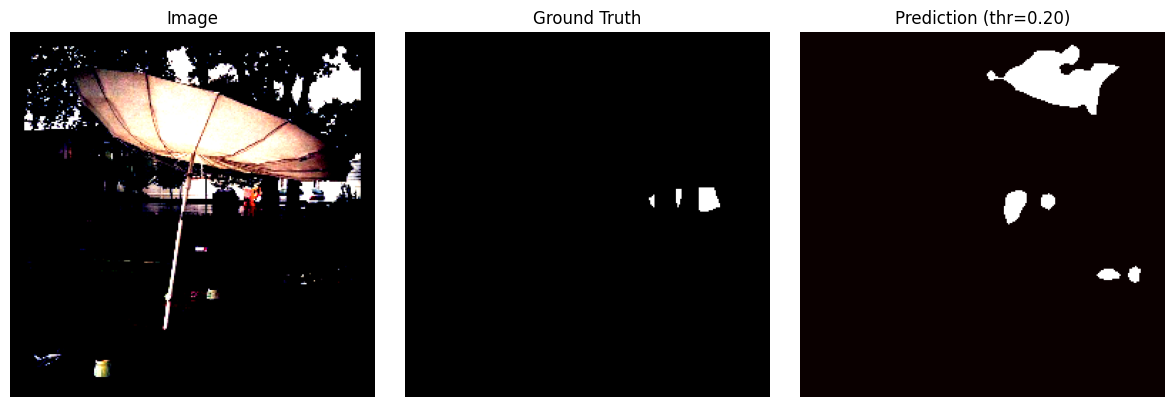

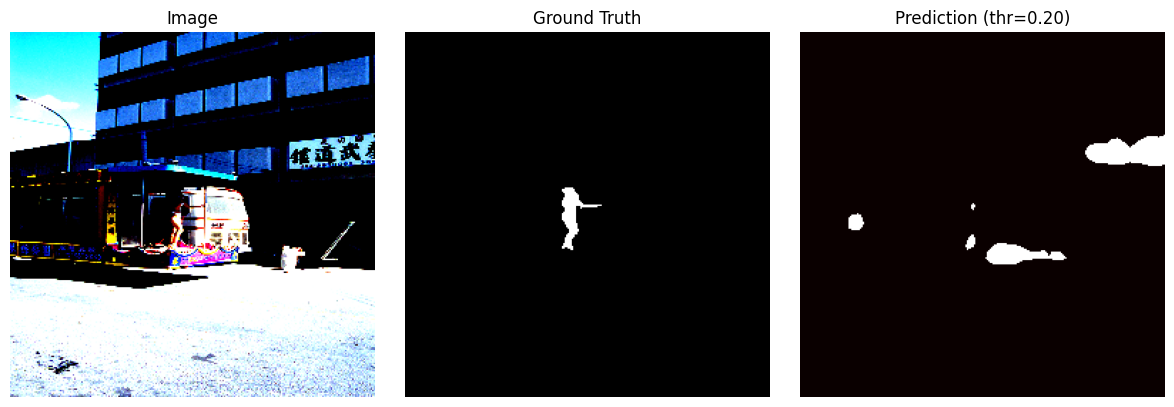

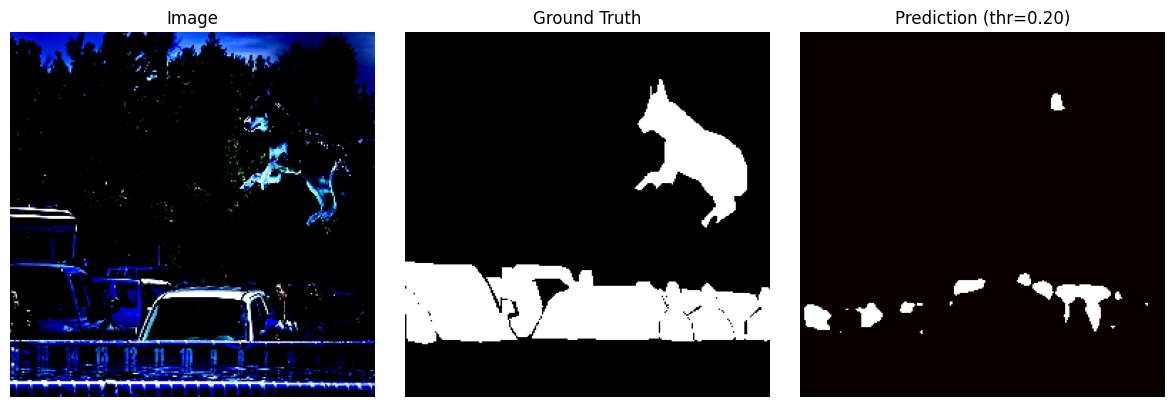

In [15]:
# ============================================================
# 10) THRESHOLD SWEEP ON VALIDATION (pick best binarization)
# ============================================================
@torch.no_grad()
def evaluate_threshold(model, loader, thresholds=np.linspace(0.2, 0.8, 13)):
    model.eval()
    results = []
    for thr in thresholds:
        tot_iou, tot_dice, batches = 0.0, 0.0, 0
        for images, masks in loader:
            images, masks = images.to(device), masks.to(device)
            with torch.cuda.amp.autocast(enabled=(device.type=='cuda')):
                logits = model(images)
            iou, dice = batch_metrics_from_logits(logits, masks, thr=float(thr))
            tot_iou += iou; tot_dice += dice; batches += 1
        results.append((float(thr), tot_iou/batches, tot_dice/batches))
    return results

thr_results = evaluate_threshold(model, val_loader)
best_thr_by_dice = max(thr_results, key=lambda x: x[2])
best_thr_by_iou  = max(thr_results, key=lambda x: x[1])

print("\nThreshold sweep (thr, mean IoU, mean Dice):")
for thr, miou, mdice in thr_results:
    print(f"{thr:.2f}  IoU={miou:.4f}  Dice={mdice:.4f}")

print(f"\nBest threshold by Dice: {best_thr_by_dice[0]:.2f} (Dice={best_thr_by_dice[2]:.4f}, IoU={best_thr_by_dice[1]:.4f})")
print(f"Best threshold by IoU : {best_thr_by_iou[0]:.2f} (IoU={best_thr_by_iou[1]:.4f}, Dice={best_thr_by_iou[2]:.4f})")

# Optional: show predictions again with best threshold
show_predictions(model, val_ds, num=3, thr=best_thr_by_dice[0])
